In [1]:
import typing as tp

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as to
import torch.utils.data as td
import torchvision as tv
import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
train_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.Resize((256, 256)),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize((256, 256)),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = tv.datasets.ImageFolder("car_data/car_data/train/", transform=train_transform)
valid_ds = tv.datasets.ImageFolder("car_data/car_data/test/", transform=valid_transform)

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
@torch.no_grad()
def evaluate(
        classifier: nn.Module,
        criterion: tp.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        loader: td.DataLoader,
        device: str = "cuda:0"
) -> float:
    classifier.eval()
    loss = 0
    progress = tqdm.tqdm(loader, desc="validation")

    for images, classes in progress:
        logits = classifier(images.to(device))
        l_val = criterion(logits, classes.to(device)).cpu().item()
        loss += l_val

        progress.set_postfix_str(f"loss={l_val:.5f}")

    return loss / len(loader)


def train(
        classifier: nn.Module,
        criterion: tp.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        loader: td.DataLoader,
        optimizer: to.Optimizer,
        device: str = "cuda:0"
) -> float:
    classifier.train()
    loss_value = 0
    progress = tqdm.tqdm(loader, desc="training")

    for images, classes in progress:
        optimizer.zero_grad()
        logits = classifier(images.to(device))
        loss = criterion(logits, classes.to(device))
        l_val = loss.detach().cpu().item()

        loss.backward()
        optimizer.step()

        loss_value += l_val
        progress.set_postfix_str(f"loss={l_val:.5f}")

    return loss_value / len(loader)

In [5]:
len(valid_ds.classes), len(train_ds.classes)

(196, 196)

In [6]:
from adasmooth import AdaSmooth

DEVICE = "cuda:0"
EPOCHS = 10
BATCH_SZ = 1024
CLASSES = 196

adam_losses = []
adas_losses = []

adam_model = AlexNet(num_classes=CLASSES)
ada_smooth_model = AlexNet(num_classes=CLASSES)

adam_optim = to.Adam(adam_model.parameters(), lr=1e-4)
ada_smooth = AdaSmooth(ada_smooth_model.parameters(), lr=1e-4, betas=(0.5, 0.99))

criterion = nn.CrossEntropyLoss()

train_loader = td.DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True)
valid_loader = td.DataLoader(valid_ds, batch_size=BATCH_SZ, shuffle=False)

In [7]:
best = None

for e in range(EPOCHS):
    train_loss = train(adam_model, criterion, train_loader, adam_optim, DEVICE)
    valid_loss = evaluate(adam_model, criterion, valid_loader, DEVICE)
    adam_losses.append((train_loss, valid_loss))

validation: 100%|████████████████████████████████████████████████████████████████| 8/8 [02:26<00:00, 18.35s/it, loss=2.94704]

CPU times: user 1d 7h 39min 37s, sys: 7d 4h 5min 19s, total: 8d 11h 44min 56s
Wall time: 49min 58s


In [8]:
best = None

for e in range(EPOCHS):
    train_loss = train(ada_smooth_model, criterion, train_loader, ada_smooth, DEVICE)
    valid_loss = evaluate(ada_smooth_model, criterion, valid_loader, DEVICE)
    adas_losses.append((train_loss, valid_loss))

validation: 100%|████████████████████████████████████████████████████████████████| 8/8 [02:17<00:00, 17.18s/it, loss=5.40543]

CPU times: user 1d 5h 44min 6s, sys: 7d 5min 15s, total: 8d 5h 49min 22s
Wall time: 50min 56s


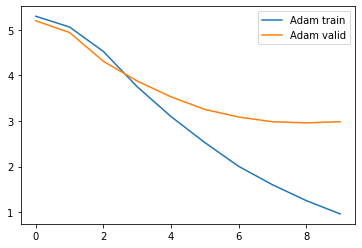

In [9]:
adam_train_losses = [l[0] for l in adam_losses]
adam_valid_losses = [l[1] for l in adam_losses]

plt.plot(adam_train_losses, label="Adam train")
plt.plot(adam_valid_losses, label="Adam valid")
plt.legend()

In [10]:
import numpy as np


@torch.no_grad()
def calc_metrics(
        classifier: nn.Module,
        loader: td.DataLoader,
        device: str = "cuda:0"
) -> tp.Tuple[np.ndarray, np.ndarray]:
    true = []
    pred = []
    classifier.eval()

    for images, classes in tqdm.tqdm(loader):
        logits = classifier(images.to(device))
        preds = logits.argmax(dim=1).detach().cpu()

        pred.append(preds)
        true.append(classes)

    return torch.cat(true, dim=0).numpy(), torch.cat(pred, dim=0).numpy()

In [11]:
true, pred = calc_metrics(adam_model, valid_loader)
f1_score(true, pred, average="macro"), recall_score(true, pred, average="macro"), precision_score(true, pred,
                                                                                                  average="macro")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:12<00:00, 16.59s/it]


(0.3518562253190232, 0.35576615130994016, 0.37206099977321155)

In [12]:
true, pred = calc_metrics(ada_smooth_model, valid_loader)

f1_score(true, pred, average="macro"), recall_score(true, pred, average="macro"), precision_score(true, pred,
                                                                                                  average="macro")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:13<00:00, 16.63s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0019125628286866603, 0.003417573504435532, 0.0019073100186732751)

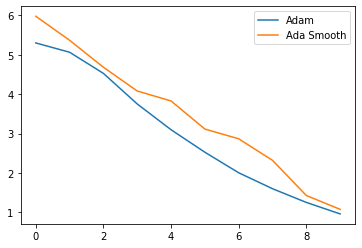

In [18]:
adam_train_losses = [l[0] for l in adam_losses]
adam_valid_losses = [l[1] for l in adam_losses]

adas_train_losses = [l[0] for l in adas_losses]
adas_valid_losses = [l[1] for l in adas_losses]

plt.plot(adam_train_losses, label="Adam")
plt.plot(adas_train_losses, label="Ada Smooth")
plt.legend()

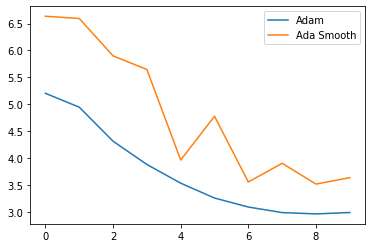

In [17]:
plt.plot(adam_valid_losses, label="Adam")
plt.plot(adas_valid_losses, label="Ada Smooth")
plt.legend()